In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

Now let’s load the dataset into the panda’s data frame and print its first five rows.

In [2]:
df = pd.read_csv('Rainfall.csv')
df.head()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,rainfall,sunshine,winddirection,windspeed
0,1,1025.9,19.9,18.3,16.8,13.1,72,49,yes,9.3,80.0,26.3
1,2,1022.0,21.7,18.9,17.2,15.6,81,83,yes,0.6,50.0,15.3
2,3,1019.7,20.3,19.3,18.0,18.4,95,91,yes,0.0,40.0,14.2
3,4,1018.9,22.3,20.6,19.1,18.8,90,88,yes,1.0,50.0,16.9
4,5,1015.9,21.3,20.7,20.2,19.9,95,81,yes,0.0,40.0,13.7


Now let’s check the size of the dataset.

In [3]:
df.shape

(366, 12)

Let's check which column of the dataset contains which type of data.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day                     366 non-null    int64  
 1   pressure                366 non-null    float64
 2   maxtemp                 366 non-null    float64
 3   temparature             366 non-null    float64
 4   mintemp                 366 non-null    float64
 5   dewpoint                366 non-null    float64
 6   humidity                366 non-null    int64  
 7   cloud                   366 non-null    int64  
 8   rainfall                366 non-null    object 
 9   sunshine                366 non-null    float64
 10           winddirection  365 non-null    float64
 11  windspeed               365 non-null    float64
dtypes: float64(8), int64(3), object(1)
memory usage: 34.4+ KB


As per the above information regarding the data in each column, we can observe that there are no null values.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
day,366.0,15.756831,8.823592,1.0,8.000,16.00,23.000,31.0
pressure,366.0,1013.742623,6.414776,998.5,1008.500,1013.00,1018.100,1034.6
maxtemp,366.0,26.191257,5.978343,7.1,21.200,27.75,31.200,36.3
temparature,366.0,23.747268,5.632813,4.9,18.825,25.45,28.600,32.4
mintemp,366.0,21.894536,5.594153,3.1,17.125,23.70,26.575,30.0
dewpoint,366.0,19.989071,5.997021,-0.4,16.125,21.95,25.000,26.7
humidity,366.0,80.177596,10.062470,36.0,75.000,80.50,87.000,98.0
cloud,366.0,71.128415,21.798012,0.0,58.000,80.00,88.000,100.0
sunshine,366.0,4.419399,3.934398,0.0,0.500,3.50,8.200,12.1
winddirection,365.0,101.506849,81.723724,10.0,40.000,70.00,190.000,350.0


#Data Cleaning
The data which is obtained from the primary sources is termed the raw data and required a lot of preprocessing before we can derive any conclusions from it or do some modeling on it. Those preprocessing steps are known as data cleaning and it includes, outliers removal, null value imputation, and removing discrepancies of any sort in the data inputs.

In [6]:
df.isnull().sum()

,0
day,0
pressure,0
maxtemp,0
temparature,0
mintemp,0
dewpoint,0
humidity,0
cloud,0
rainfall,0
sunshine,0


So there is one null value in the ‘winddirection’ as well as the ‘windspeed’ column. But what’s up with the column name wind direction?

In [7]:
df.columns

Index(['day', 'pressure ', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity ', 'cloud ', 'rainfall', 'sunshine', '         winddirection',
       'windspeed'],
      dtype='object')

Here we can observe that there are unnecessary spaces in the names of the columns let’s remove that.

In [8]:
df.rename(str.strip,
          axis='columns',
          inplace=True)
df.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'rainfall', 'sunshine', 'winddirection',
       'windspeed'],
      dtype='object')

Now it’s time for null value imputation.

In [9]:
for col in df.columns:

  #Checking if the column contains
  # any null values
  if df[col].isnull().sum() > 0:
    val = df[col].mean()
    df[col] = df[col].fillna(val)


df.isnull().sum().sum()

0

Exploratory Data Analysis
EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. Here we will see how to check the data imbalance and skewness of the data.

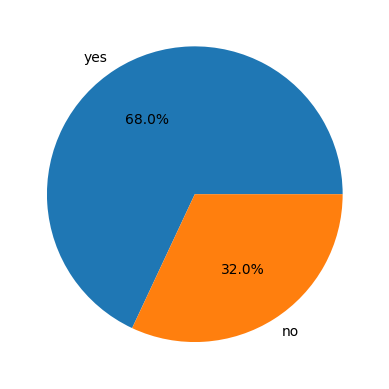

In [10]:
plt.pie(df['rainfall'].value_counts().values,
        labels = df['rainfall'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [12]:
df.groupby('rainfall').mean()


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
rainfall,,,,,,,,,,,
no,15.623932,1014.576923,27.070940,24.053846,21.957265,18.766667,73.000000,51.256410,7.586325,103.076923,19.275214
yes,15.819277,1013.350602,25.777912,23.603213,21.865060,20.563454,83.550201,80.465863,2.931325,100.769104,22.599747


maxtemp is relatively lower on days of rainfall.

dewpoint value is higher on days of rainfall.

humidity is high on the days when rainfall is expected.

Obviously, clouds must be there for rainfall.

sunshine is also less on days of rainfall.

windspeed is higher on days of rainfall.


The observations we have drawn from the above dataset are very much similar to what is observed in real life as well.

In [13]:
features = list(df.select_dtypes(include =
                                 np.number).columns)
features.remove('day')
print(features)

['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']


Let’s check the distribution of the continuous features given in the dataset.

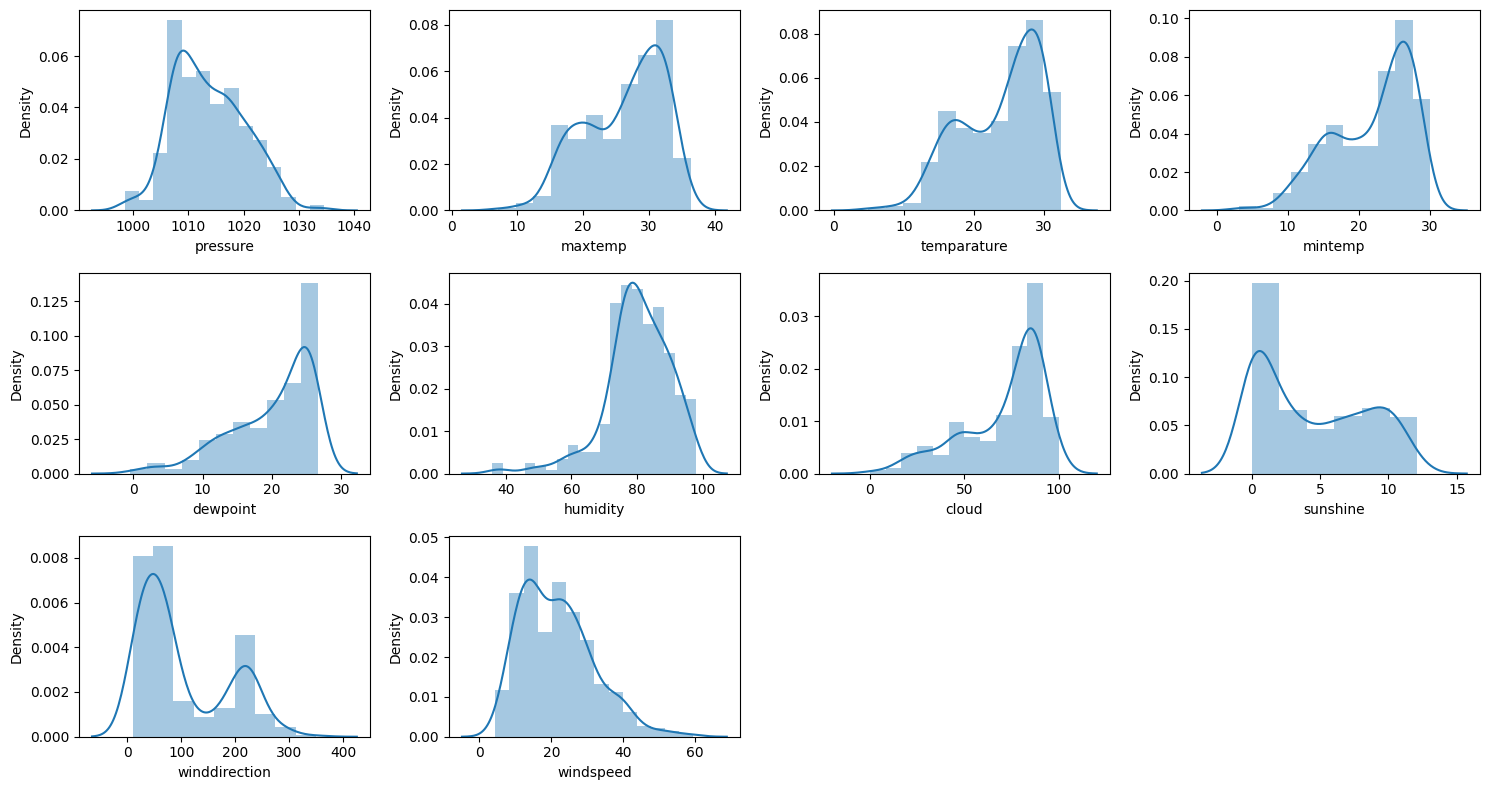

In [14]:
plt.subplots(figsize=(15,8))

for i, col in enumerate(features):
  plt.subplot(3,4, i+1)
  sb.distplot(df[col])
plt.tight_layout()
plt.show()

Let’s draw boxplots for the continuous variable to detect the outliers present in the data.

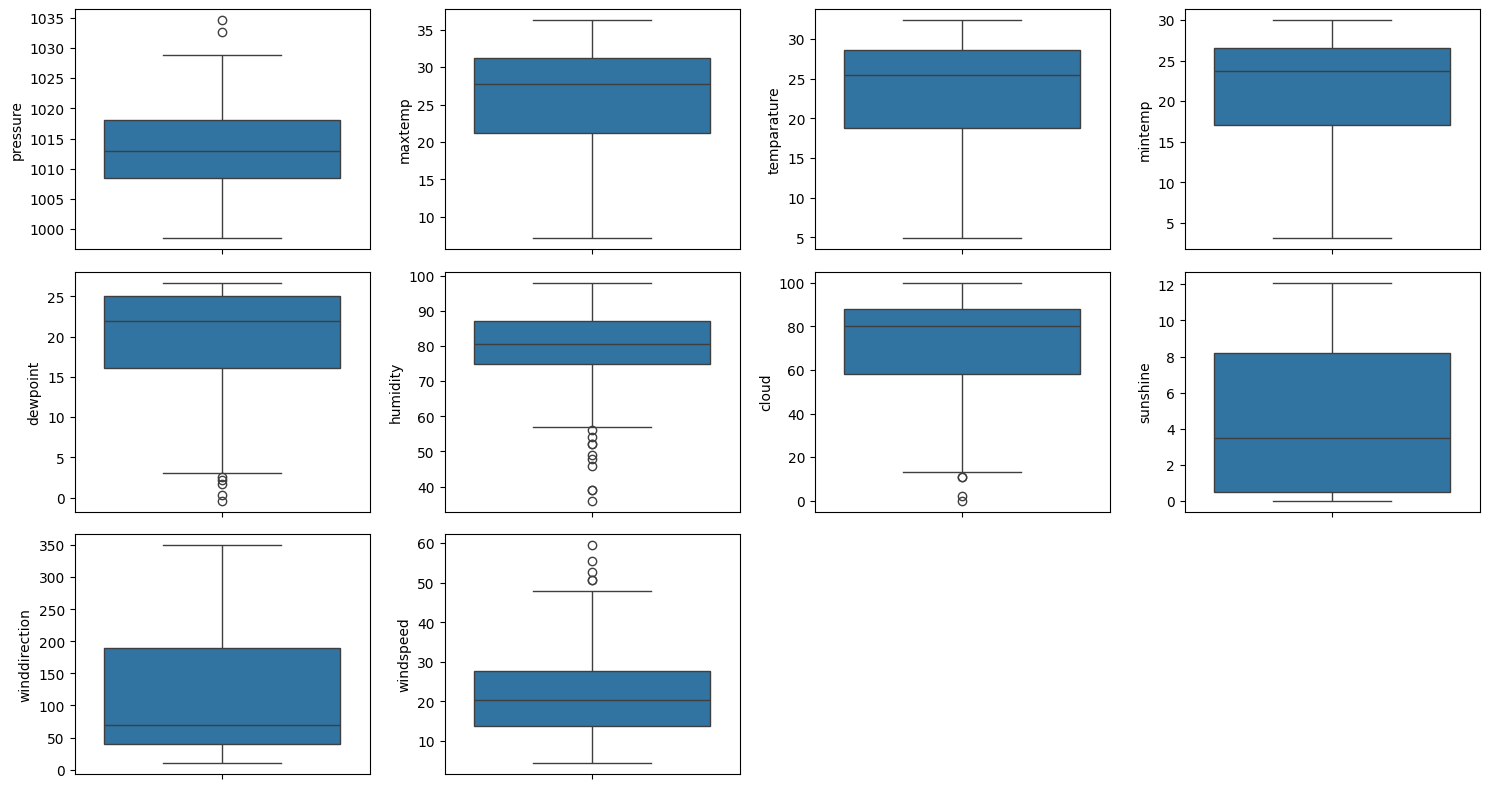

In [15]:
plt.subplots(figsize=(15,8))

for i,col in enumerate(features):
  plt.subplot(3,4,i+1)
  sb.boxplot(df[col])
plt.tight_layout()
plt.show()


There are outliers in the data but sadly we do not have much data so, we cannot remove this.

In [16]:
df.replace({'yes':1, 'no':0}, inplace=True)

Sometimes there are highly correlated features that just increase the dimensionality of the feature space and do not good for the model’s performance. So we must check whether there are highly correlated features in this dataset or not.

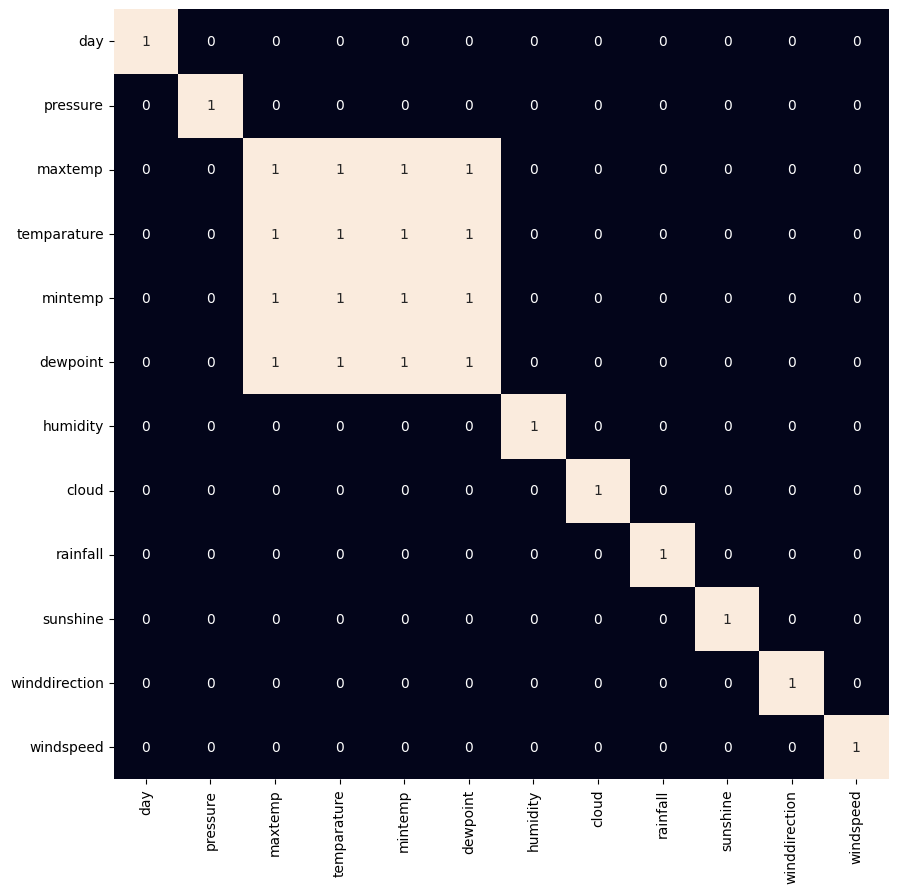

In [18]:
plt.figure(figsize=(10,10))
sb.heatmap(df.corr() > 0.8 ,
           annot=True,
           cbar=False)
plt.show()

Now we will remove the highly correlated features ‘maxtemp’ and ‘mintemp’. But why not temp or dewpoint? This is because temp and dewpoint provide distinct information regarding the weather and atmospheric conditions.

In [19]:
df.drop(['maxtemp', 'mintemp'], axis=1, inplace=True)

#Model Training
Now we will separate the features and target variables and split them into training and testing data by using which we will select the model which is performing best on the validation data.

In [20]:
features = df.drop(['day', 'rainfall'], axis=1)
target = df.rainfall

As we found earlier that the dataset we were using was imbalanced so, we will have to balance the training data before feeding it to the model.

In [21]:
X_train, X_val, \
    Y_train, Y_val = train_test_split(features,
                                      target,
                                      test_size=0.2,
                                      stratify=target,
                                      random_state=2)

# As the data was highly imbalanced we will
# balance it by adding repetitive rows of minority class.
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=22)
X, Y = ros.fit_resample(X_train, Y_train)


The features of the dataset were at different scales so, normalizing it before training will help us to obtain optimum results faster along with stable training.

In [22]:
# Normalizing the features for stable and fast training.
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)


Now let’s train some state-of-the-art models for classification and train them on our training data.

LogisticRegression


XGBClassifier


SVC

In [24]:
models = [LogisticRegression(), XGBClassifier(), SVC(kernel='rbf', probability=True)]

for i in range(3):
  models[i].fit(X, Y)

  print(f'{models[i]} : ')

  train_preds = models[i].predict_proba(X)
  print('Training Accuracy : ', metrics.roc_auc_score(Y, train_preds[:,1]))

  val_preds = models[i].predict_proba(X_val)
  print('Validation Accuracy : ', metrics.roc_auc_score(Y_val, val_preds[:,1]))
  print()


LogisticRegression() : 
Training Accuracy :  0.8893967324057473
Validation Accuracy :  0.8966666666666667

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...) : 
Training Accuracy :  0.9999999999999999
Validation Accuracy :  0.8391666666666666

SVC(probability=True) : 
Training Accuracy :  0.9

#Model Evaluation
From the above accuracies, we can say that Logistic Regression and support vector classifier are satisfactory as the gap between the training and the validation accuracy is low. Let’s plot the confusion matrix as well for the validation data using the SVC model.

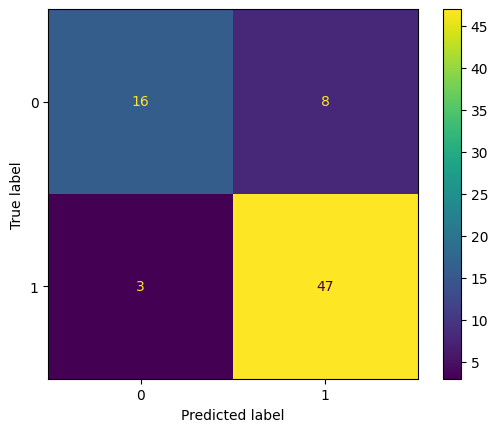

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics

ConfusionMatrixDisplay.from_estimator(models[2], X_val, Y_val)
plt.show()

# This code is modified by Susobhan Akhuli


Let’s plot the classification report as well for the validation data using the SVC model.

In [27]:
print(metrics.classification_report(Y_val,
                                    models[2].predict(X_val)))


              precision    recall  f1-score   support

           0       0.84      0.67      0.74        24
           1       0.85      0.94      0.90        50

    accuracy                           0.85        74
   macro avg       0.85      0.80      0.82        74
weighted avg       0.85      0.85      0.85        74

